# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-4"}
    download(args)
    extract("data/Model_IV.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vGkfEgEiapZoHUt1E6Tlhi-hKJ7dF2Ke
From (redirected): https://drive.google.com/uc?id=1vGkfEgEiapZoHUt1E6Tlhi-hKJ7dF2Ke&confirm=t&uuid=8dff8883-5767-4783-b309-510e1f272a7b
To: /opt/repo/GSoC-23/data/Model_IV.tgz
100%|██████████| 1.91G/1.91G [00:29<00:00, 64.8MB/s]


In [2]:
import gc
import copy
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler


from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
class AxionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_name = "axion"
        self.class_folder = os.path.join(self.root_dir, self.class_name)
        self.file_list = [f for f in os.listdir(self.class_folder) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.file_list[idx]
        file_path = os.path.join(self.class_folder, file_name)
        data = np.load(file_path, allow_pickle=True)
        image = data[0]
        weight = data[1]
        image = 255 * (image / image.max())
        image = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image.float(), weight
    

trainset = AxionDataset(
    root_dir='data/Model_IV/train',
    transform = train_transforms
)

testset = AxionDataset(
    root_dir='data/Model_IV/val',
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [5]:
lr = 0.0001
epochs = 30
gamma = 0.5
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [6]:
from models import coordinates, networks, transformers, ET

tf_default_opts = {
    "in_channels": 1,
    "kernel_size": 3,
    "nf": 32,
    "strides": (2, 1),
}

# classification network defaults
net_default_opts = {
    "input_channels": 1,
    "output_size": 1,
    "nf": 32,
    "p_dropout": 0.3,
    "pad_mode": (None, "cyclic"),
    "pool": (True, True, False),
}

ET_ = ET(
    tfs=[
        transformers.ShearX,
        transformers.HyperbolicRotation,
        transformers.PerspectiveX,
        transformers.PerspectiveY,
    ],
    coords=coordinates.logpolar_grid,
    net=networks.BasicCNN,
    equivariant=True,
    tf_opts=tf_default_opts,
    net_opts=net_default_opts,
)
ET_.model = ET_.model.to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(ET_.model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)

# Training


In [7]:
all_train_loss = []
all_test_loss = []


best_loss = np.inf

for epoch in range(epochs):
    epoch_loss = 0
    ET_.model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.type('torch.FloatTensor').to(device)

        output = ET_.model(data)
        loss = criterion(output, label).float()
        tr_loss_epoch.append(loss.item())
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        epoch_loss += loss / len(train_loader)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))


    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = ET_.model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())

            epoch_val_loss += val_loss.item() / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(ET_)

    print(
        f"Epoch : {epoch+1} - train loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}%"
    )
ET_._save("equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 32/32 [00:03<00:00,  9.47it/s]


Epoch : 1 - train loss : 378.7155 - val_loss : 315.4438%


100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


Epoch : 2 - train loss : 248.1959 - val_loss : 186.1740%


100%|██████████| 32/32 [00:02<00:00, 12.55it/s]


Epoch : 3 - train loss : 138.1543 - val_loss : 96.4771%


100%|██████████| 32/32 [00:03<00:00, 10.59it/s]


Epoch : 4 - train loss : 67.0575 - val_loss : 42.7289%


100%|██████████| 32/32 [00:03<00:00, 10.38it/s]


Epoch : 5 - train loss : 27.3358 - val_loss : 15.8952%


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch : 6 - train loss : 9.5796 - val_loss : 5.0749%


100%|██████████| 32/32 [00:02<00:00, 13.27it/s]


Epoch : 7 - train loss : 3.4630 - val_loss : 2.2486%


100%|██████████| 32/32 [00:02<00:00, 12.81it/s]


Epoch : 8 - train loss : 1.9855 - val_loss : 1.7183%


100%|██████████| 32/32 [00:02<00:00, 12.80it/s]


Epoch : 9 - train loss : 1.7250 - val_loss : 1.6599%


100%|██████████| 32/32 [00:02<00:00, 11.75it/s]


Epoch : 10 - train loss : 1.6944 - val_loss : 1.6382%


100%|██████████| 32/32 [00:03<00:00,  9.99it/s]


Epoch : 11 - train loss : 1.6820 - val_loss : 1.6916%


100%|██████████| 32/32 [00:03<00:00, 10.26it/s]


Epoch : 12 - train loss : 1.6736 - val_loss : 1.6311%


100%|██████████| 32/32 [00:03<00:00,  9.11it/s]


Epoch : 13 - train loss : 1.6790 - val_loss : 1.6475%


100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


Epoch : 14 - train loss : 1.6791 - val_loss : 1.6567%


100%|██████████| 32/32 [00:03<00:00, 10.57it/s]


Epoch : 15 - train loss : 1.6814 - val_loss : 1.6745%


100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


Epoch : 16 - train loss : 1.6761 - val_loss : 1.6205%


100%|██████████| 32/32 [00:03<00:00, 10.47it/s]


Epoch : 17 - train loss : 1.6821 - val_loss : 1.6370%


100%|██████████| 32/32 [00:03<00:00, 10.37it/s]


Epoch : 18 - train loss : 1.6746 - val_loss : 1.6448%


100%|██████████| 32/32 [00:03<00:00,  9.98it/s]


Epoch : 19 - train loss : 1.6721 - val_loss : 1.6367%


100%|██████████| 32/32 [00:03<00:00, 10.54it/s]


Epoch : 20 - train loss : 1.6742 - val_loss : 1.6515%


100%|██████████| 32/32 [00:03<00:00, 10.32it/s]


Epoch : 21 - train loss : 1.6647 - val_loss : 1.6303%


100%|██████████| 32/32 [00:03<00:00, 10.41it/s]


Epoch : 22 - train loss : 1.6612 - val_loss : 1.6433%


100%|██████████| 32/32 [00:03<00:00, 10.28it/s]


Epoch : 23 - train loss : 1.6700 - val_loss : 1.6286%


100%|██████████| 32/32 [00:03<00:00, 10.36it/s]


Epoch : 24 - train loss : 1.6811 - val_loss : 1.6536%


100%|██████████| 32/32 [00:03<00:00, 10.30it/s]


Epoch : 25 - train loss : 1.6721 - val_loss : 1.6386%


100%|██████████| 32/32 [00:03<00:00,  9.84it/s]


Epoch : 26 - train loss : 1.6785 - val_loss : 1.6457%


100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


Epoch : 27 - train loss : 1.6743 - val_loss : 1.6337%


100%|██████████| 32/32 [00:03<00:00, 10.30it/s]


Epoch : 28 - train loss : 1.6734 - val_loss : 1.6379%


100%|██████████| 32/32 [00:03<00:00, 10.63it/s]


Epoch : 29 - train loss : 1.6699 - val_loss : 1.6423%


100%|██████████| 32/32 [00:03<00:00, 10.19it/s]

Epoch : 30 - train loss : 1.6732 - val_loss : 1.6443%


# Plotting Loss and Accuracy


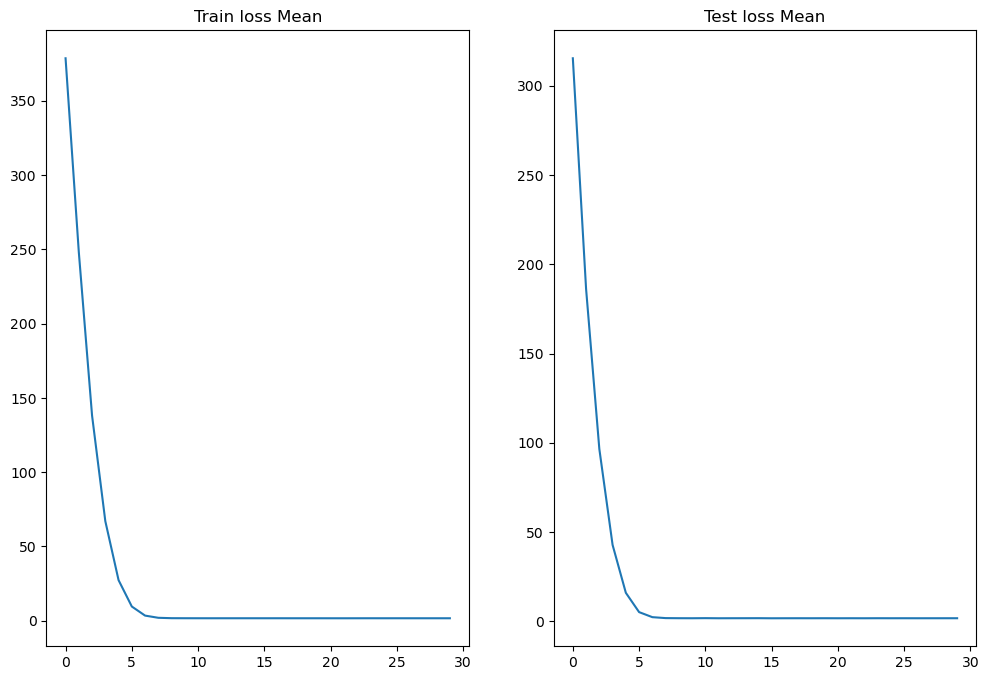

In [8]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)

# Loading Best Model


In [9]:
ET_ = ET(
    tfs=[
        transformers.ShearX,
        transformers.HyperbolicRotation,
        transformers.PerspectiveX,
        transformers.PerspectiveY,
    ],
    coords=coordinates.logpolar_grid,
    net=networks.BasicCNN,
    equivariant=True,
    tf_opts=tf_default_opts,
    net_opts=net_default_opts,
    load_path="equi_nn.pth",
)
ET_.model = ET_.model.to(device)

# Testing


In [10]:
import torch.nn.functional as F
with torch.no_grad():
    ET_.model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = ET_.model(x)
        
        # Calculate metrics
        rmse = torch.sqrt(F.mse_loss(_y, y))
        mse = F.mse_loss(_y, y)
        mae = F.l1_loss(_y, y)
        
        rmse_list.append(rmse.item())
        mse_list.append(mse.item())
        mae_list.append(mae.item())

# Calculate overall metrics
avg_rmse = np.mean(rmse_list)
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)

print("Average RMSE:", avg_rmse)
print("Average MSE:", avg_mse)
print("Average MAE:", avg_mae)

100%|██████████| 32/32 [00:02<00:00, 12.60it/s]

Average RMSE: 3.3211763002392445
Average MSE: 11.057006561415715
Average MAE: 3.124060190078028
